In [1]:
import pandas as pd

import numpy as np
from tqdm import tqdm

from numba import jit

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in the dataframe you want to clean, can be a csv, hdf
traindf = pd.read_csv("./data/training_set_VU_DM.csv")

In [3]:
@jit(nopython=True, parallel=True)
def calculate_mean_per_propid(unique_propids, 
                                    col_propids, 
                                    col_price, 
                                    col_mean, 
                                    col_std, 
                                    col_no_hotels, 
                                    col_correct_price, 
                                    col_nights,
                                    col_new_mean,
                                    col_new_std):
    
    total = len(unique_propids)

    for i, propid in enumerate(unique_propids):
        
        if i % 1000 == 0:
            print(i, "/", total)
        
        indices = np.where(col_propids == propid)[0]

        prices = col_price[indices]
        mean_price = np.mean(prices)
        std_price = np.std(prices)
        
        col_mean[indices] = mean_price
        col_std[indices] = std_price
        col_no_hotels[indices] = indices.size
        
        if std_price > 100:
            col_correct_price[indices] = col_price[indices] / col_nights[indices]
            prices = col_correct_price[indices]
            mean_price = np.mean(prices)
            std_price = np.std(prices)
            
        col_new_mean[indices] = mean_price
        col_new_std[indices] = std_price

        return col_mean, col_no_hotels

In [4]:
def compute_numba(df):
    # add columns
    columnames = list(df.columns)
    columnames.extend(["avg_price_propid", "std_avg_price_propid", "amount_hotels", 
                       "avg_price_propid_after", "std_avg_price_propid_after"])

    df = df.reindex(columns=columnames)

    # copy prices (for now, at the end we will just update the price i suppose)
    df["price_correction"] = df["price_usd"]

    # get unique propids and put them into numpy array
    propids = np.array(df["prop_id"].unique())
   
    means, no_hotels = calculate_mean_per_propid(propids,
                                        df['prop_id'].to_numpy(),
                                        df['price_usd'].to_numpy(),
                                        df['avg_price_propid'].to_numpy(),
                                        df['std_avg_price_propid'].to_numpy(),
                                        df['amount_hotels'].to_numpy(),
                                        df['price_correction'].to_numpy(),
                                        df['srch_length_of_stay'].to_numpy(),
                                        df['avg_price_propid_after'].to_numpy(),
                                        df['std_avg_price_propid_after'].to_numpy())    
    return df

In [5]:
print("TEST")
df = compute_numba(traindf)
display(df[['prop_id', 'amount_hotels', 'avg_price_propid', 'price_usd', 'std_avg_price_propid', 'srch_length_of_stay', 'price_correction', 'avg_price_propid_after', 'std_avg_price_propid_after']][df['prop_id'] == 37304])
display(df[['prop_id', 'amount_hotels', 'avg_price_propid', 'price_usd', 'std_avg_price_propid', 'srch_length_of_stay', 'price_correction', 'avg_price_propid_after', 'std_avg_price_propid_after']])
print(len(df['amount_hotels'].notna()))

TEST
Unique propids:  129113
0 / 129113
HOI!
[    445    7824   16691   49406   51306   53528   55704   61118   70573
   72942   95809   99476   99998  103400  110168  133668  139362  140813
  144672  148984  154712  172622  174168  179640  183798  186687  199077
  204554  222954  227667  231593  232257  234584  245956  273781  275264
  275583  281217  291971  309673  315530  320949  326219  329809  334426
  339832  347338  360034  368573  368695  368919  370608  371206  379034
  382709  386789  390011  393612  395720  403795  417155  417188  423085
  430556  439999  441727  451637  452027  452529  458260  475771  480309
  485645  489613  521481  522295  533794  537780  564225  567514  571986
  575244  578058  581697  582933  589613  589785  599480  604291  609328
  614658  618811  622123  626677  632092  648404  653761  661555  667822
  677560  688649  688891  716571  723851  724789  726668  739482  746569
  768319  774845  785542  787724  826159  830320  832044  836448  839329
  8403

,prop_id,amount_hotels,avg_price_propid,price_usd,std_avg_price_propid,srch_length_of_stay,price_correction,avg_price_propid_after,std_avg_price_propid_after
445,37304,617.0,127.730681,90.00,165.729146,1,90.000000,98.5246,168.186984
7824,37304,617.0,127.730681,200.00,165.729146,1,200.000000,98.5246,168.186984
16691,37304,617.0,127.730681,75.00,165.729146,2,37.500000,98.5246,168.186984
49406,37304,617.0,127.730681,52.00,165.729146,2,26.000000,98.5246,168.186984
51306,37304,617.0,127.730681,77.00,165.729146,4,19.250000,98.5246,168.186984
...,...,...,...,...,...,...,...,...,...
4900545,37304,617.0,127.730681,146.07,165.729146,7,20.867143,98.5246,168.186984
4917198,37304,617.0,127.730681,60.00,165.729146,1,60.000000,98.5246,168.186984
4924029,37304,617.0,127.730681,260.00,165.729146,2,130.000000,98.5246,168.186984
4930756,37304,617.0,127.730681,3766.00,165.729146,1,3766.000000,98.5246,168.186984


,prop_id,amount_hotels,avg_price_propid,price_usd,std_avg_price_propid,srch_length_of_stay,price_correction,avg_price_propid_after,std_avg_price_propid_after
0,893,612.0,118.758742,104.77,17.764203,1,104.77,118.758742,17.764203
1,10404,583.0,152.054082,170.74,390.593156,1,170.74,115.123190,199.201662
2,21315,551.0,168.540871,179.80,345.165849,1,179.80,130.074599,179.270492
3,27348,460.0,82.598870,602.77,305.433044,1,602.77,64.152478,154.605742
4,29604,665.0,137.648135,143.58,432.975724,1,143.58,103.923122,218.806596
...,...,...,...,...,...,...,...,...,...
4958342,77700,47.0,131.241702,118.00,16.596682,1,118.00,131.241702,16.596682
4958343,88083,38.0,84.545789,89.00,15.040461,1,89.00,84.545789,15.040461
4958344,94508,43.0,116.537209,99.00,22.925359,1,99.00,116.537209,22.925359
4958345,128360,37.0,150.336757,139.00,27.176210,1,139.00,150.336757,27.176210


4958347


In [6]:
arr = np.array([11, 12, 13, 14, 15, 16, 17, 15, 11, 12, 14, 15, 16, 17])
indices = np.where(arr==15)
print(indices)
print(indices[0].size)

(array([ 4,  7, 11], dtype=int64),)
3


Std before:  1303.301460381125
Std after:  667.0744311235957


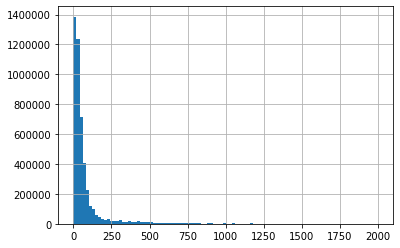

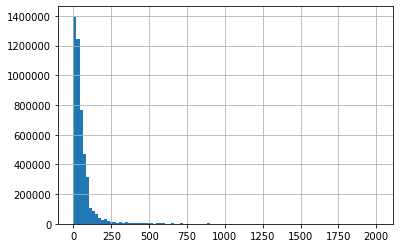

In [17]:
print("Std before: ", df['std_avg_price_propid'].mean())
print("Std after: ", df['std_avg_price_propid_after'].mean())
df['std_avg_price_propid'][df['std_avg_price_propid'] < 2000].hist(bins=100)

plt.figure()
df['std_avg_price_propid_after'][df['std_avg_price_propid'] < 2000].hist(bins=100)

In [29]:
display(df[['prop_id','std_avg_price_propid', 'std_avg_price_propid_after']][df['std_avg_price_propid_after'] > 10000])
display(df[df['prop_id'] == 13878])

display(df[['prop_id', 'amount_hotels', 'avg_price_propid', 'price_usd', 'std_avg_price_propid', 'srch_length_of_stay', 'price_correction', 'avg_price_propid_after', 'std_avg_price_propid_after']][df['prop_id'] == 13878])



,prop_id,std_avg_price_propid,std_avg_price_propid_after
692,1736,72780.954376,18192.802258
701,47392,63974.557442,15991.967773
949,88389,11493.057438,11498.548696
951,98851,10870.067464,10874.196425
952,107721,173280.710562,43315.994855
...,...,...,...
4957028,85663,12396.050693,12398.506235
4957029,88332,12159.033832,12162.494635
4957030,94654,11242.113491,11245.970268
4957033,130392,11137.288415,11139.833963


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,avg_price_propid,std_avg_price_propid,amount_hotels,avg_price_propid_after,std_avg_price_propid_after,price_correction
291,30,2013-02-11 01:28:38,24,216,NaN,NaN,219,13878,3,4.0,...,NaN,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,20.755556
2381,158,2013-05-15 10:59:40,24,219,NaN,NaN,219,13878,3,4.0,...,16.0,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,105.560000
17173,1171,2012-11-17 12:36:37,24,216,NaN,NaN,219,13878,3,4.0,...,NaN,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,10.125833
51099,3380,2013-03-08 00:04:56,24,216,NaN,NaN,219,13878,3,4.0,...,6.0,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,25.968333
65518,4367,2013-01-05 15:09:18,24,219,NaN,NaN,219,13878,3,4.0,...,NaN,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,109.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917831,330077,2013-06-27 14:54:24,24,216,NaN,NaN,219,13878,3,4.0,...,NaN,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,14.511250
4934874,331219,2013-01-06 16:20:07,14,100,NaN,NaN,219,13878,3,4.0,...,NaN,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,49.636667
4937611,331398,2013-01-15 21:43:03,24,216,NaN,NaN,219,13878,3,4.0,...,NaN,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,36.078000
4941491,331668,2013-06-05 11:33:19,5,219,NaN,NaN,219,13878,3,4.0,...,NaN,0,NaN,0,725.02997,10559.168411,335.0,144.397302,1506.967051,24.571429


,prop_id,amount_hotels,avg_price_propid,price_usd,std_avg_price_propid,srch_length_of_stay,price_correction,avg_price_propid_after,std_avg_price_propid_after
291,13878,335.0,725.02997,186.80,10559.168411,9,20.755556,144.397302,1506.967051
2381,13878,335.0,725.02997,105.56,10559.168411,1,105.560000,144.397302,1506.967051
17173,13878,335.0,725.02997,121.51,10559.168411,12,10.125833,144.397302,1506.967051
51099,13878,335.0,725.02997,155.81,10559.168411,6,25.968333,144.397302,1506.967051
65518,13878,335.0,725.02997,109.01,10559.168411,1,109.010000,144.397302,1506.967051
...,...,...,...,...,...,...,...,...,...
4917831,13878,335.0,725.02997,116.09,10559.168411,8,14.511250,144.397302,1506.967051
4934874,13878,335.0,725.02997,148.91,10559.168411,3,49.636667,144.397302,1506.967051
4937611,13878,335.0,725.02997,180.39,10559.168411,5,36.078000,144.397302,1506.967051
4941491,13878,335.0,725.02997,172.00,10559.168411,7,24.571429,144.397302,1506.967051


In [31]:
df.to_hdf("corrected_price.hdf", key='df')